## 분류 실습 - 캐글 신용카드 사기 검출

- 사기 검출이나 이상 검출과 같은 데이터 세트는 레이블 값이 극도로 불균형한 분포를 가지는 경우가 많음.
- 이상 현상은 전체 데이터에서 차지하는 비중이 적을 수 밖에 없기 때문

### 언더 샘플링과 오버 샘플링의 이해
- 지도학습에서 극도로 불균형한 레이블 값 분포로 인한 문제점을 해결하기 위한 방법 : 오버 샘플링, 언더 샘플링
- 오버 샘플링 : 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식
- 언더 샘플링 : 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시킴.
#### 오버 샘플링이 유리한 경우가 많아 상대적으로 더 많이 사용됨!

### 데이터 일차 가공 및 모델 학습 / 예측 / 평가

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('creditcard.csv')
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
# v로 시작하는 피처의 의미는 알 수 없음. Amount = 신용카드 트랜잭션 금액, class = label
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [3]:
# 데이터 사전 가공 수행
from sklearn.model_selection import train_test_split

# 인자로 입력 받은 DataFrame을 복사한 뒤, Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    df_copy.drop('Time', axis = 1, inplace = True)
    return df_copy

In [4]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df = None):
    # 인자로 입력된 데이터 프레임의 사전 데이터 가공이 완료된 복사 데이터프레임 반환
    df_copy = get_preprocessed_df(df)
    
    # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]

    # train_test_split()으로 학습과 테스트 데이터 분할. stratify = y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [5]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts() / y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts() / y_test.shape[0] * 100) # 비율 거의 같음.

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    # ROC - AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차 행렬')
    print(confusion)
    
    # ROC - AUC 추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [7]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=100)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85283    12]
 [   64    84]]
정확도 : 0.9991, 정밀도 : 0.8750, 재현율 : 0.5676, F1 : 0.6885, AUC : 0.9566


In [8]:
# 인자로 사이킷런의 Estimator 객체와 학습 / 테스트 데이터 세트를 입력받아서 학습 / 예측 / 평가 수행
def get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [9]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test = X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도 : 0.9995, 정밀도 : 0.9573, 재현율 : 0.7568, F1 : 0.8453, AUC : 0.9790


### 데이터 분포도 변환 후 모델 학습/예측/평가
- 대부분의 선형 모델은 중요 피처들의 값이 정규 분포 형태를 유지하는 것을 선호함.

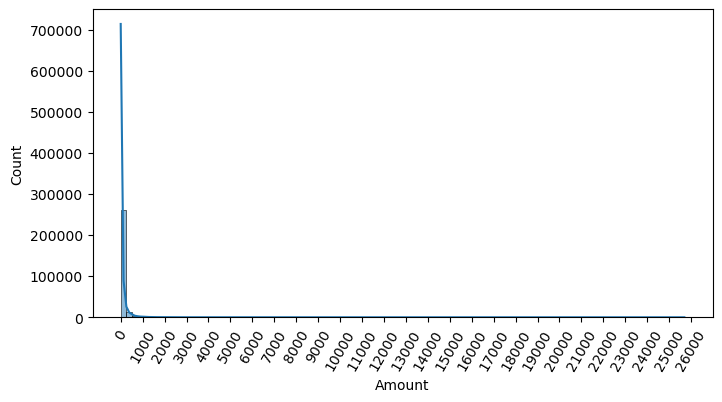

In [10]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation = 60)
sns.histplot(card_df['Amount'], bins = 100, kde = True)
plt.show() # 1000불 이하인 데이터가 대부분, 꼬리가 긴 형태의 분포 곡선

In [11]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
    return df_copy

In [12]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test = X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test = X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도 : 0.9992, 정밀도 : 0.8654, 재현율 : 0.6081, F1 : 0.7143, AUC : 0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   37   111]]
정확도 : 0.9995, 정밀도 : 0.9569, 재현율 : 0.7500, F1 : 0.8409, AUC : 0.9779


In [13]:
# 로그 변환은 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중 하나.
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
    return df_copy

In [14]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test = X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test = X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도 : 0.9992, 정밀도 : 0.8812, 재현율 : 0.6014, F1 : 0.7149, AUC : 0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도 : 0.9995, 정밀도 : 0.9576, 재현율 : 0.7635, F1 : 0.8496, AUC : 0.9796


#### 레이블이 극도로 불균일한 데이터 세트에서 로지스틱 회귀는 데이터 변환 시 약간은 불안정한 성능 결과를 보여주고 있음.
#### LIGHTGBM을 사용하자!

### 이상치 데이터 제거 후 모델 학습/예측/평가

<Axes: >

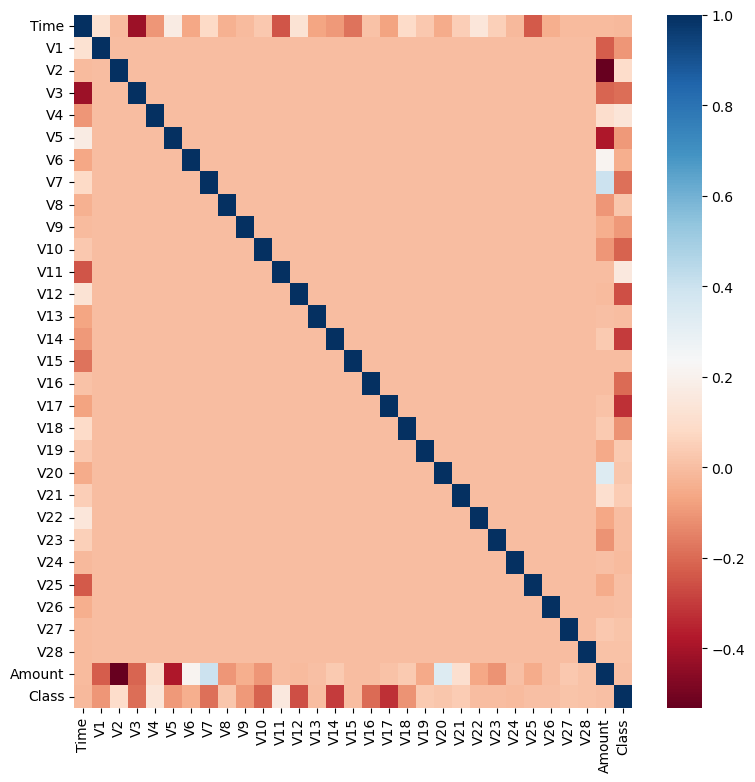

In [15]:
import seaborn as sns

plt.figure(figsize = (9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap = 'RdBu')

In [16]:
def get_outlier(df = None, column = None, weight = 1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4분위와 3/4분위 지점을 np.percentile로 구함.
    fraud = df[df['Class'] == 1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)

    # IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함.
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight

    # 최댓값보다 크거나 최솟값보다 작은 값을 이상치 데이터로 설정하고 데이터 프레임 index 반환
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [17]:
outlier_index = get_outlier(df = card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스 : ', outlier_index)

이상치 데이터 인덱스 :  Index([8296, 8615, 9035, 9252], dtype='int64')


In [18]:
# get_preprocessed_df()를 로그 변환 후 V14 피처으 ㅣ이상치 데이터를 삭제하는 로직으로 변경

def get_preprocessed_df(df = None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
    # 이상치 데이터 삭제하는 로직
    outlier_index = get_outlier(df = df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis = 0, inplace = True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test = X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test = X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도 : 0.9993, 정밀도 : 0.8750, 재현율 : 0.6712, F1 : 0.7597, AUC : 0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도 : 0.9996, 정밀도 : 0.9603, 재현율 : 0.8288, F1 : 0.8897, AUC : 0.9780


### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [19]:
# 반드시 학습 데이터 세트만 오버 샘플링
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포 :\n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포 :
 Class
0    199020
1    199020
Name: count, dtype: int64


In [20]:
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test = X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도 : 0.9723, 정밀도 : 0.0542, 재현율 : 0.9247, F1 : 0.1023, AUC : 0.9737


In [21]:
# 로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무나 많은 Class = 1 데이터를 학습
# 실제 테스트 데이터 세트에서 예측을 지나치게 Class = 1로 적용해 정밀도가 급격히 떨어지게 됨.

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize = (8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # X축, Y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall Value')
    plt.legend; plt.grid()
    plt.show()

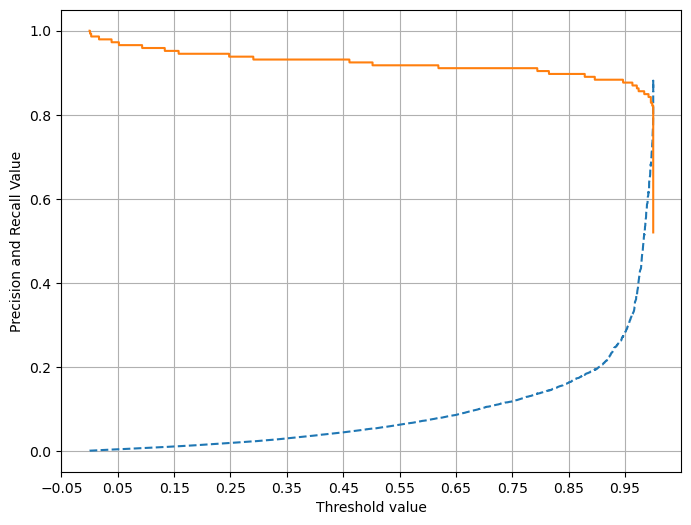

In [22]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

In [23]:
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test = X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도 : 0.9996, 정밀도 : 0.9118, 재현율 : 0.8493, F1 : 0.8794, AUC : 0.9814


##### SMOTE를 적용하면 재현율은 높아지나, 정밀도는 낮아짐.
정밀도보다 재현율을 높이는 것이 머신러닝의 주요한 목표인 경우 SMOTE를 적용하면 좋음!